# Lab #5
Noam Yan<br>
<br>
### 1. Load DataSet

In [39]:
import pickle
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets, layers, models


In [8]:
# Training sample and normalization
higgs_df = pd.read_pickle("higgs_100000_pt_1000_1200.pkl")
qcd_df = pd.read_pickle("qcd_100000_pt_1000_1200.pkl")

### 2. Explore features

In [9]:
cols = higgs_df.columns.values

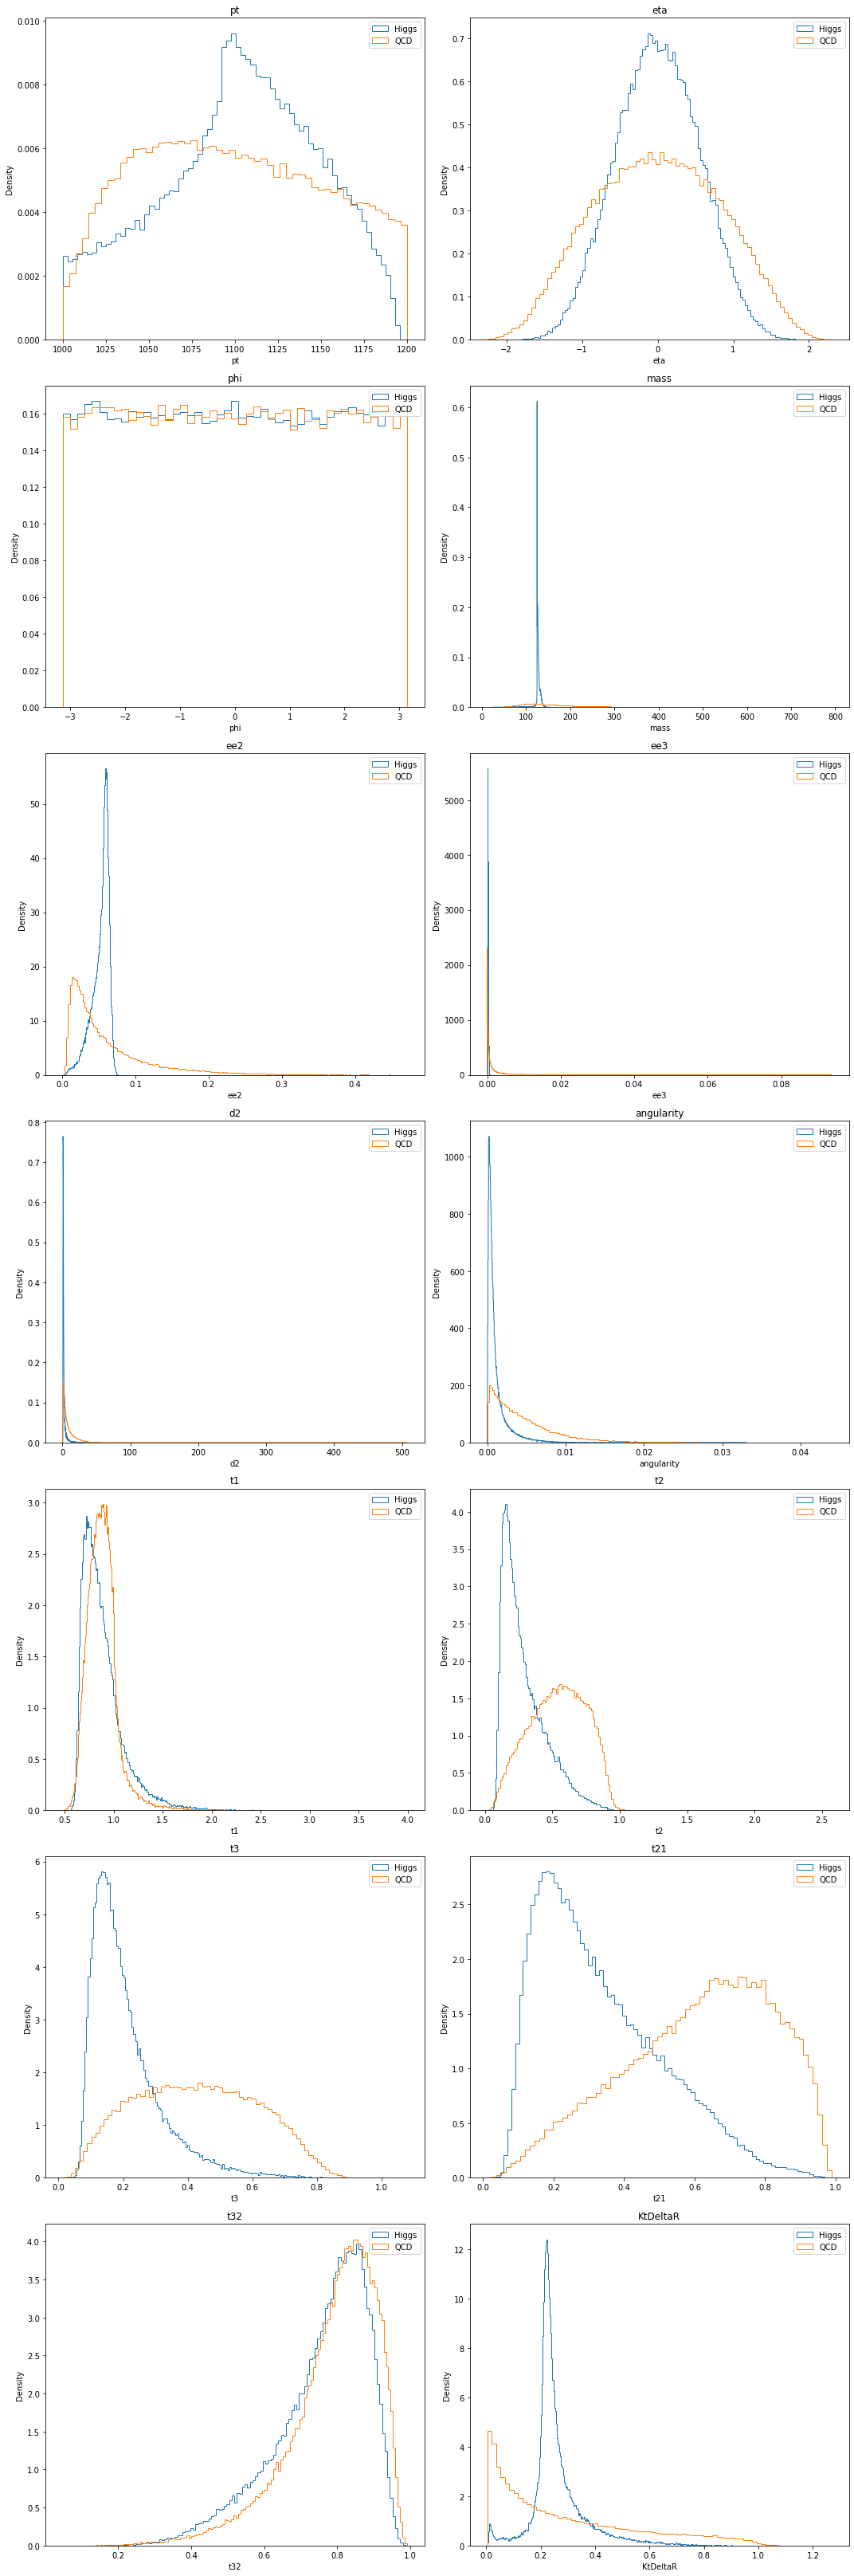

In [25]:
plt.rcParams["figure.figsize"] = (15,45)
fig,ax = plt.subplots(cols.shape[0]//2, 2)
for i, col in enumerate(cols):
    ax[i//2,i%2].hist(higgs_df[col],'auto',density=True,histtype='step',label="Higgs")
    ax[i//2,i%2].hist(qcd_df[col],'auto',density=True,histtype='step', label='QCD')
    ax[i//2,i%2].legend()
    ax[i//2,i%2].set_xlabel(col)
    ax[i//2,i%2].set_ylabel('Density')
    ax[i//2,i%2].title.set_text(col)
plt.tight_layout()
plt.show()


The plots above shows the distribution of each feature. Through comparison between two datasets, we can have a rough understanding about which feature can help us distinguish them. The more disparate are those two distribution, the easier we can discriminate by such feature. <br>
It can be seen that not every feature make contribution to distinguish Higgs and QCD. Features "phi", "t32" provide limited discrimination power between signal and background. Therefore, when we apply models, we tends to drop these two features to save computational capability.

### 3. Feature Correlation

<AxesSubplot:>

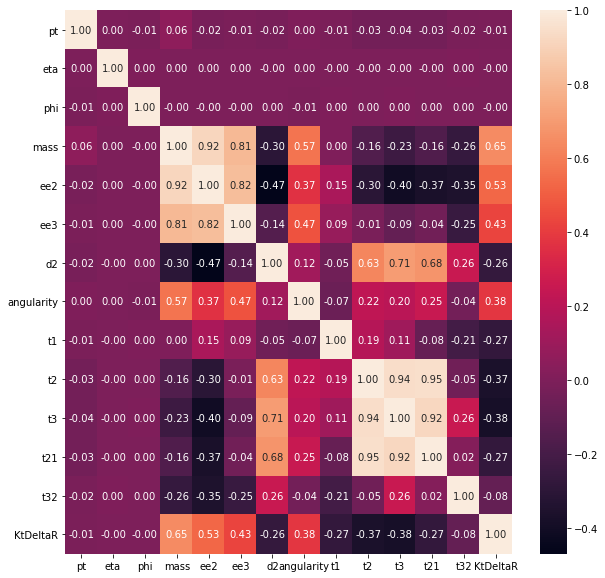

In [14]:
corr = pd.concat([higgs_df,qcd_df],axis=0).corr()
plt.rcParams["figure.figsize"] = (8,8)
sns.heatmap(corr, square=False, annot=True, fmt='.2f')

In this plot, 0 means no correlation, positve number means positively relevant, and vice versa on negative. <br>
The reason I draw this plot is that features with high correlation, for example linear correlation y = ax + b, is redundant to Machine Learning. The neural networks can easily get this relationship itself. Again, in order to save computational capability, we will drop redundant features.
<br><br>
Here, I concatenate the two datasets and intuitively choose 0.8, which is generally used in industry, as my threshold to see which features have higher correlation. 

In [23]:
corr[abs(corr)>0.8]

,pt,eta,phi,mass,ee2,ee3,d2,angularity,t1,t2,t3,t21,t32,KtDeltaR
pt,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eta,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phi,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mass,NaN,NaN,NaN,1.000000,0.919606,0.806400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ee2,NaN,NaN,NaN,0.919606,1.000000,0.823623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ee3,NaN,NaN,NaN,0.806400,0.823623,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
angularity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
t1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
t2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.944155,0.948598,NaN,NaN


There are two sets of features have high correlation: {"mass", "ee2", "ee3"} and {"t2", "t3", "t21"}, so I will keep "mass" and "t21" and remove the rest.

### 4. Further Exploration
To get a baseline of AUC, I will simply choose XGBoost to see whether I can get a good prediction based on my selections. <br>
Train:Test = 8:2. 

In [87]:
# Concat and Label
higgs_df['label'] = np.ones(higgs_df.shape[0],dtype='int')
qcd_df['label'] = np.zeros(qcd_df.shape[0],dtype='int')
df = pd.concat([higgs_df,qcd_df],axis=0,ignore_index=True)

# Drop useless features
df_ori = pd.DataFrame(df)
df.drop(['phi','t32',"ee2", "ee3","t2", "t3"], axis=1, inplace=True)

# Train Val Test Split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1],df.iloc[:,-1], test_size=0.2,random_state=42)

In [88]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test,y_test)

param = { "max_depth": 4, 
        "eta": 1,
        "objective": "binary:logistic"}
num_round = 3
bst = xgb.train(param,dtrain,num_round)

pred = bst.predict(dtest)

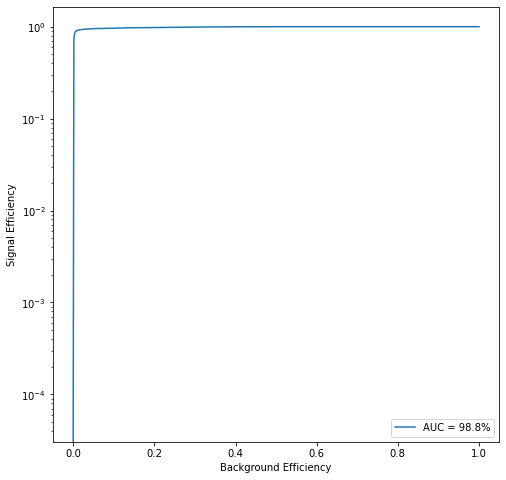

In [89]:
from sklearn.metrics import roc_curve, auc
plt.rcParams["figure.figsize"] = (8,8)
fpr, tpr, threshold = roc_curve(y_test,pred)
auc1 = auc(fpr, tpr)
plt.semilogy()
plt.plot(fpr, tpr, label='AUC = %.1f%%'%(auc1*100.))
plt.ylabel("Signal Efficiency")
plt.xlabel("Background Efficiency")
plt.legend()
plt.show()

In [90]:
feat_importance = sorted(bst.get_score(importance_type='weight').items(), key=lambda x: x[1], reverse = True) 
feat_importance

[('mass', 16),
 ('d2', 14),
 ('KtDeltaR', 4),
 ('angularity', 4),
 ('t1', 2),
 ('t21', 1),
 ('eta', 1)]

For this simple problem, we got a pretty nice result by applying XGBoost and from that we can get the 4 most significant features: {"mass", "d2", "ktDeltaR", "Angularity"}.


### Conlusion
<br><br>
1\. The file comes from ATLAS particle detector. We have two Datasets: Higgs Jets and QCD Jets. Based on the Standard Model of Elementary Particles, Quantum Chromodynamics (QCD) generates quarks and gluons, which is our background data. Higgs boson interacts with a set of scalar particles carrying no Standard Model charge, which is considered as the signal.<br>
2\. Both Datasets have 14 columns, which are high-level features of jets: ‘pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR'.

| Feature | Description | Funtion |
| :--- | :--- |:---:|
| pt | Transverse Momentum| $$\sqrt{p^2_x + p^2_y}$$ |
| eta | Pseudorapidity | $$-ln[\tan(\frac{\theta}{2})]$$ |
| phi | Azimuthal Angle | $$\cos^{-1}(\frac{x}{r})$$ |
| mass| Invariant Mass | E<sup>2</sup>=p<sup>2</sup>+m<sup>2</sup> |
| ee2 | 2nd E<sub>CF</sub> Ratio | $$\sum_{i<j \in J} p_{T,i}p_{T,j}\Delta R_{ij} * \frac{1}{p^2_{T,J}}$$ |
| ee3 | 3rd E<sub>CF</sub> Ratio | $$\sum_{i<j<k \in J} p_{T,i}p_{T,j}p_{T,k}\Delta R_{ij}\Delta R_{ik} \Delta R_{jk} * \frac{1}{p^3_{T,J}}$$ |
| d2 | E<sub>CF3</sub>*$(\frac{E_{CF1}}{E_{CF2}})^3$ | $$E_{CF3}*(\frac{E_{CF1}}{E_{CF2}})^3$$ |
| angularity | Angularity | $$\frac{1}{m_J} \sum_{i \in J} E_i \sin^{-2}(\Theta_i)*\cos^3(\Theta_i)$$ |
| t1 | 1-Subjettiness | $$\tau_N = \frac{1}{d_0}\sum_{k=1}^M(p_{T,k}\times \Delta R_{min,k})$$ |
| t2 | 2-Subjettiness  | $$\tau_N = \frac{1}{d_0}\sum_{k=1}^M(p_{T,k}\times \Delta R_{min,k})$$ |
| t3 | 3-Subjettiness  | $$\tau_N = \frac{1}{d_0}\sum_{k=1}^M(p_{T,k}\times \Delta R_{min,k})$$ |
| t21 | 2-to-1-Subjettiness  | $$\frac{t2}{t1}$$ |
| t32 | 3-to-2-Subjettiness  | $$\frac{t3}{t2}$$ |
| KtDeltaR | Jet substructure moment | $$\Delta R=\sqrt{\Delta\eta^2+\Delta\varphi^2}$$ |


3\. Among the features, due to the ambiguity in discrimination and relatively high correlation, six features are dropped ('phi','t32',"ee2", "ee3","t2", "t3"). <br>
4\. By applying XGBoost, we get a excellent result, the AUC is up to 98.8%. <br>
5\. Through feature importance analysis, we find 4 most significant features: {"mass", "d2", "ktDeltaR", "Angularity"}. <br>